In [1]:
import os
import random
import string

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from PIL import Image
import cv2 as cv
import shutil

This notebook will generate all the images following the Nucleus model.
It will crop in 600x600 images and create all the associated masks (1 image per mask)
This can work on the original wafer images, and the artificial images.

In [2]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

In [3]:
DATASET_NUMBER = 1

In [4]:
# Wafer file to crop
file = "../augmented_dataset/wafer_with_fluo_RGB_"+str(DATASET_NUMBER)+".tif"
wafer = Image.open(file)
seg_tissues = pd.read_csv("../dataset/silicon_wafer_"+str(DATASET_NUMBER)+"/source_sections_mag_scale3.txt", sep="\t|,", header=None, names=index, engine='python')
seg_mag = pd.read_csv("../dataset/silicon_wafer_"+str(DATASET_NUMBER)+"/source_sections_tissue_scale3.txt", sep="\t|,", header=None, names=index, engine='python')



In [23]:
test = cv.imread(file,cv.IMREAD_UNCHANGED )

In [27]:
RGB_img = cv.cvtColor(test, cv.COLOR_BGR2RGB)

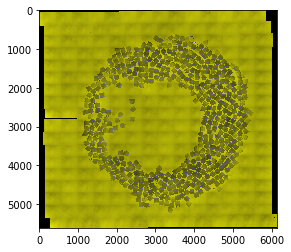

In [28]:
plt.imshow(RGB_img)

In [6]:
def generate_mask(image, points):
    # size of the image
    height = image.size[1]
    width = image.size[0]
    
    # init mask
    img_mask = np.zeros([height,width],dtype=np.uint8)
    img_mask.fill(0)
    
    cv.fillConvexPoly(img_mask, points, 255)
    
    return img_mask

In [10]:
# Height and width of the resulting section in pixels
section_size = 512

# Number of sections that will be generated
number_of_sections = 40

In [11]:

index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                               ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

# Wafer file to crop
file = "../augmented_dataset/wafer_with_fluo_RGB_"+str(DATASET_NUMBER)+".tif"
wafer = Image.open(file)
seg_tissues = pd.read_csv("../dataset/silicon_wafer_"+str(DATASET_NUMBER)+"/source_sections_tissue_scale3.txt", sep="\t|,", header=None, names=index, engine='python')
seg_mag = pd.read_csv("../dataset/silicon_wafer_"+str(DATASET_NUMBER)+"/source_sections_mag_scale3.txt", sep="\t|,", header=None, names=index, engine='python')




for i in range(1,number_of_sections+1):


    # random crop coordinates (top-left point of the cropped area)
    start_x = random.randint(0, wafer.size[0] - section_size)
    start_y = random.randint(0, wafer.size[1] - section_size)

    # cropping the wafer image
    cropped_image = wafer.crop((start_x,start_y,start_x+section_size,start_y+section_size))


    #plt.title("Cropped section"+str(i)+" :")
    #plt.show()  


    # index of all tissue part within the cropped area
    tissue_indicies = list()
    for index, row in seg_tissues.iterrows(): # iterating over sections
        points_within = 0
        for j in range(0,8,2): # iterating over the 4 points for each section
            if (start_x < row[j]-5) &  (row[j] < start_x+section_size-5) & (start_y < row[j+1]-5) &  (row[j+1]< start_y+section_size-5):
                points_within += 1
        if(points_within >= 1):
            tissue_indicies.append(index)

    # index of all magnetic part within the cropped area
    mag_indicies = list()
    for index, row in seg_mag.iterrows(): # iterating over sections
        points_within = 0
        for j in range(0,8,2): # iterating over the 4 points for each section
            if (start_x < row[j]-5) &  (row[j] < start_x+section_size-5) & (start_y < row[j+1]-5) &  (row[j+1]< start_y+section_size-5):
                points_within += 1
        if(points_within >= 1):
            mag_indicies.append(index)


    if( (len(tissue_indicies) >=3) & (len(mag_indicies) >=3) ):

        # creating directories to store results
        image_folder = f"../augmented_dataset/stage1/wafer{str(DATASET_NUMBER)}_crop"+str(i)+"/image/" 
        os.makedirs(os.path.dirname(image_folder), exist_ok=True)
        tissue_masks_folder = f"../augmented_dataset/stage1/wafer{str(DATASET_NUMBER)}_crop"+str(i)+"/tissue_masks/" 
        os.makedirs(os.path.dirname(tissue_masks_folder), exist_ok=True)
        magnetic_masks_folder = f"../augmented_dataset/stage1/wafer{str(DATASET_NUMBER)}_crop"+str(i)+"/magnetic_masks/" 
        os.makedirs(os.path.dirname(magnetic_masks_folder), exist_ok=True)

        # creating tissue part mask
        ind_img = 0
        for section_index in tissue_indicies:
            vertices = np.array(seg_tissues.loc[[section_index]]).reshape((4, 2))
            #print(vertices)

            mask = generate_mask(wafer,vertices)
            _mask = Image.fromarray(np.uint8(mask))
            _mask = _mask.crop((start_x,start_y,start_x+section_size,start_y+section_size))
            #plt.imshow(_mask)
            #plt.title("Tissue mask "+str(section_index)+" :")
            #plt.show() 

            # saving the cropped mask
            _mask.save(tissue_masks_folder+str(section_index)+".tif")
            ind_img = ind_img +1


        # creating magnetic part mask
        ind_img = 0
        for section_index in mag_indicies:
            vertices = np.array(seg_mag.loc[[section_index]], 'int32').reshape((4, 2))
            #print(vertices)

            mask = generate_mask(wafer,vertices)
            _mask = Image.fromarray(np.uint8(mask))
            _mask = _mask.crop((start_x,start_y,start_x+section_size,start_y+section_size))

            #plt.imshow(_mask)
            #plt.title("Magnetic mask "+str(section_index)+" :")
            #plt.show()



            # saving the cropped mask
            _mask.save(magnetic_masks_folder+str(section_index)+".tif")
            ind_img = ind_img +1

        # saving the cropped image
        cropped_image.save(image_folder+"wafer"+str(DATASET_NUMBER)+"_crop"+str(i)+".tif")
